<a href="https://colab.research.google.com/github/id-f/brain_mri_segmentation/blob/main/submit_segmodel_brainMRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install -q kaggle
! pip install tensorflow==2.2.0
! pip install segmentation_models

In [ ]:
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d mateuszbuda/lgg-mri-segmentation
! mkdir ./train/
! unzip lgg-mri-segmentation.zip -d train

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
#Set Parameters
im_width = 256
im_height = 256

# **Load image's path and mask's path**

In [ ]:
t_files = []
mask_files = glob('/content/train/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    t_files.append(i.replace('_mask',''))

In [ ]:
train_files = []
mask_files = glob('/content/train/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    train_files.append(i.replace('_mask',''))

print(train_files[:10])
print(mask_files[:10])

['/content/train/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_47.tif', '/content/train/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_8.tif', '/content/train/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_27.tif', '/content/train/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_49.tif', '/content/train/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_7.tif', '/content/train/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_38.tif', '/content/train/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_50.tif', '/content/train/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_52.tif', '/content/train/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_41.tif', '/content/train/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_16.tif']
[

# **Data Visualization**

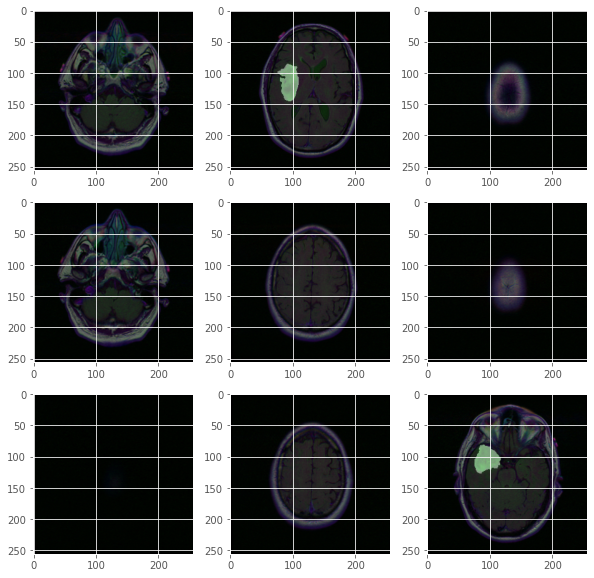

In [ ]:
#Lets plot some samples
rows,cols=3,3
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img_path=train_files[i]
    msk_path=mask_files[i]
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    msk=cv2.imread(msk_path)
    plt.imshow(img)
    plt.imshow(msk,alpha=0.4)
plt.show()

# **Create data frame and split data on train set, validation set and test set**

In [ ]:
df = pd.DataFrame(data={"filename": train_files, 'mask' : mask_files})
df_train, df_test = train_test_split(df,test_size = 0.1)
df_train, df_val = train_test_split(df_train,test_size = 0.2)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2828, 2)
(708, 2)
(393, 2)


# **Data genertator, data augmentation and adjust data**

In [ ]:
# From: https://github.com/zhixuhao/unet/blob/master/data.py
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(im_height, im_width),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

# **Define loss function and metrics**

In [ ]:
smooth=100

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

# **Using Segmentation_models (updated Define Unet) >>>**

In [ ]:
import segmentation_models as sm
K.set_image_data_format('channels_last')
BACKBONE = 'efficientnetb0'
CLASSES = ["MASK"]
preprocess_input = sm.get_preprocessing(BACKBONE)
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, input_shape=(im_height, im_width, 3), classes=n_classes, activation=activation)

Segmentation Models: using `tf.keras` framework.
16809984/16804768 [==============================] - 0s 0us/step


In [ ]:
EPOCHS = 20
BATCH_SIZE = 32
learning_rate = 1e-4

# **Training**

In [ ]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(im_height, im_width))
    
test_gener = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
    
# model = unet(input_size=(im_height, im_width, 3))


decay_rate = learning_rate / EPOCHS
opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)
model.compile(optimizer=opt, loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])

callbacks = [ModelCheckpoint('unet_brain_mri_seg.hdf5', verbose=1, save_best_only=True)]

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = test_gener,
                    validation_steps=len(df_val)/BATCH_SIZE)

Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/20
89/88 [==============================] - ETA: 0s - loss: -0.1204 - binary_accuracy: 0.9891 - iou: 0.0649 - dice_coef: 0.1208Found 708 validated image filenames.
Found 708 validated image filenames.

Epoch 00001: val_loss improved from inf to -0.09207, saving model to unet_brain_mri_seg.hdf5
89/88 [==============================] - 109s 1s/step - loss: -0.1204 - binary_accuracy: 0.9891 - iou: 0.0649 - dice_coef: 0.1208 - val_loss: -0.0921 - val_binary_accuracy: 0.9947 - val_iou: 0.0509 - val_dice_coef: 0.0959
Epoch 2/20
89/88 [==============================] - ETA: 0s - loss: -0.1735 - binary_accuracy: 0.9929 - iou: 0.0964 - dice_coef: 0.1738
Epoch 00002: val_loss improved from -0.09207 to -0.15578, saving model to unet_brain_mri_seg.hdf5
89/88 [==============================] - 107s 1s/step - loss: -0.1735 - binary_accuracy: 0.9929 - iou: 0.0964 - dice_coef: 0.1738 - val_loss: -0.1558 - val_binary_ac

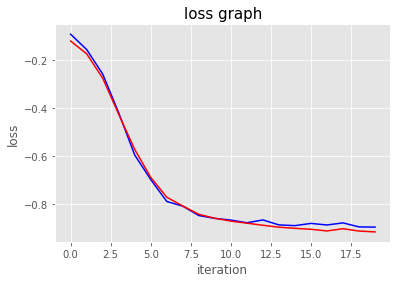

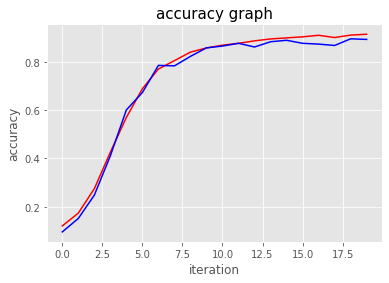

In [ ]:
a = history.history

list_traindice = a['dice_coef']
list_testdice = a['val_dice_coef']

list_trainjaccard = a['iou']
list_testjaccard = a['val_iou']

list_trainloss = a['loss']
list_testloss = a['val_loss']
plt.figure(1)
plt.plot(list_testloss, 'b-')
plt.plot(list_trainloss,'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)
plt.figure(2)
plt.plot(list_traindice, 'r-')
plt.plot(list_testdice, 'b-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('accuracy graph', fontsize = 15)
plt.show()

In [ ]:
model = load_model('unet_brain_mri_seg.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})


In [ ]:
test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
print("Test lost: ",results[0])
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

Found 393 validated image filenames.
Found 393 validated image filenames.
13/12 [===============================] - 4s 272ms/step - loss: -0.8985 - binary_accuracy: 0.9979 - iou: 0.8188 - dice_coef: 0.8994
Test lost:  -0.8985393047332764
Test IOU:  0.99793541431427
Test Dice Coefficent:  0.8187533020973206


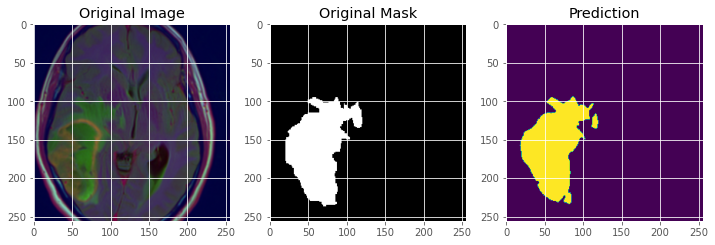

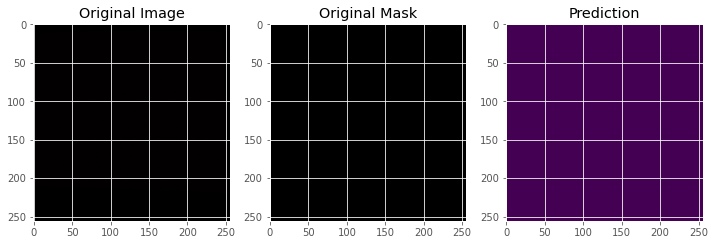

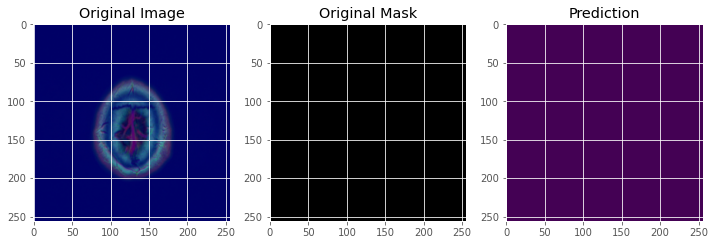

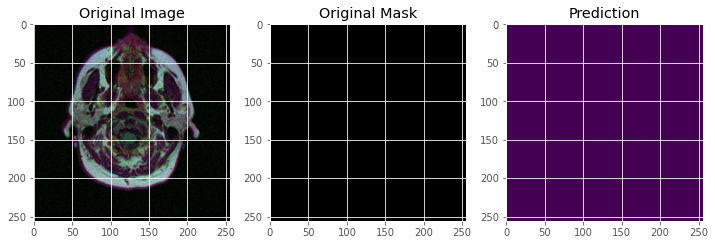

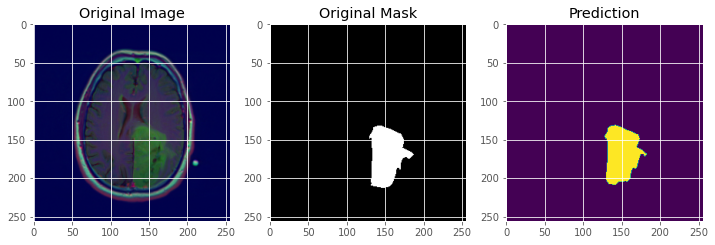

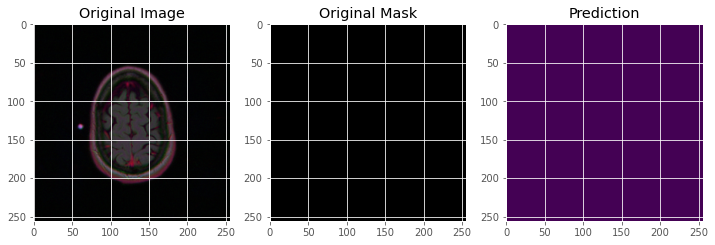

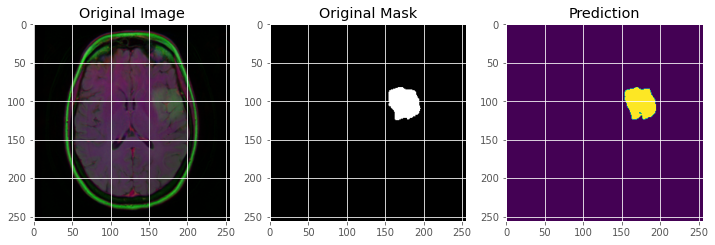

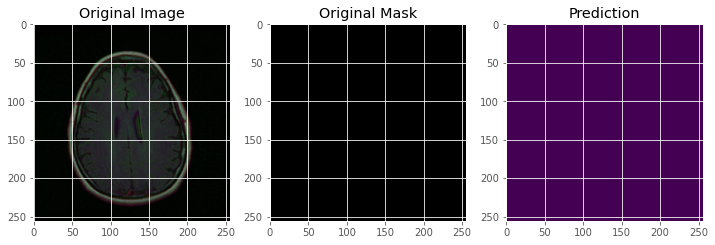

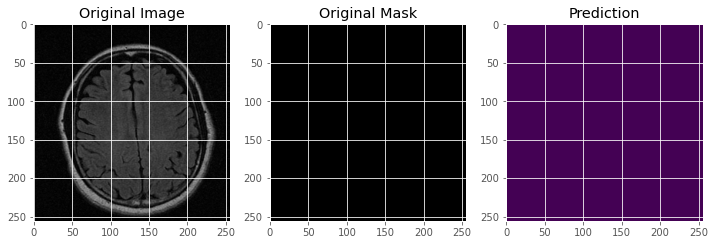

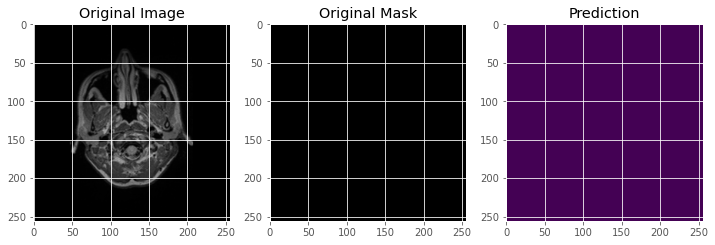

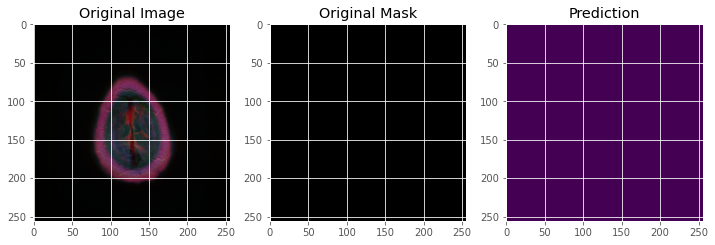

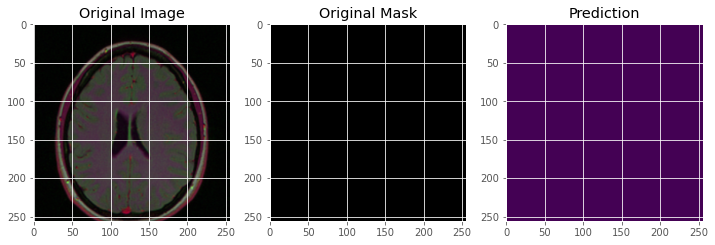

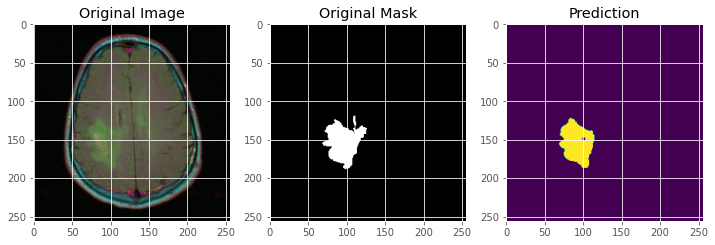

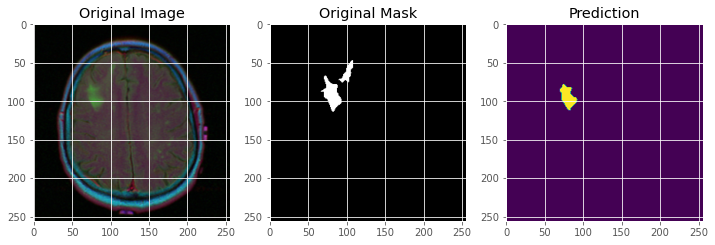

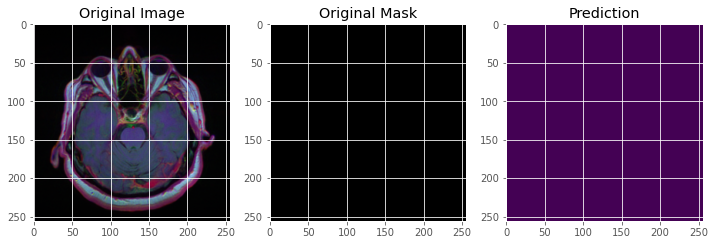

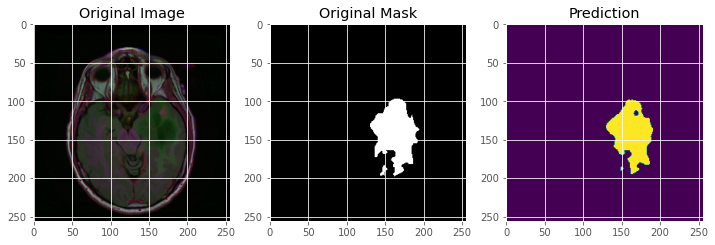

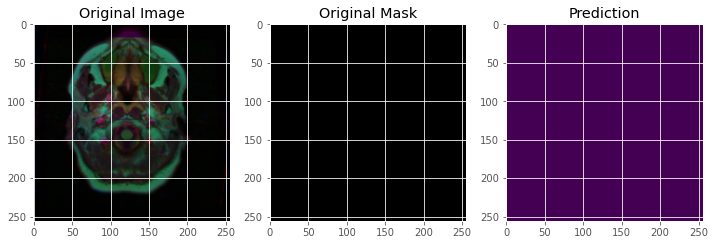

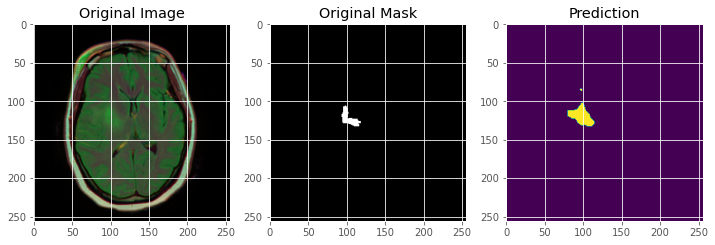

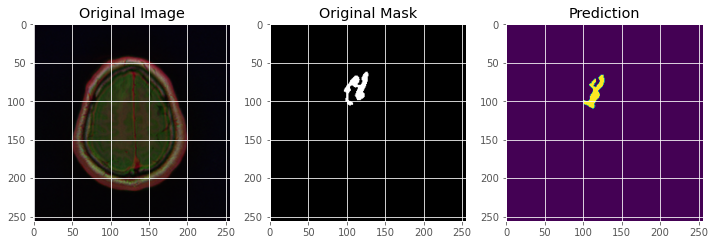

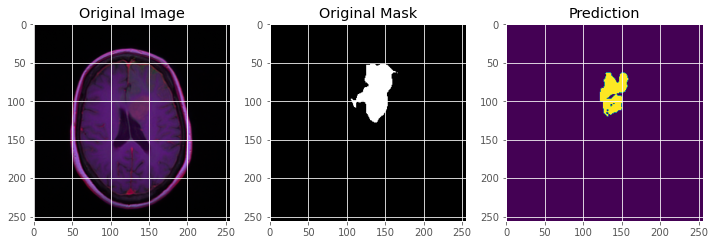

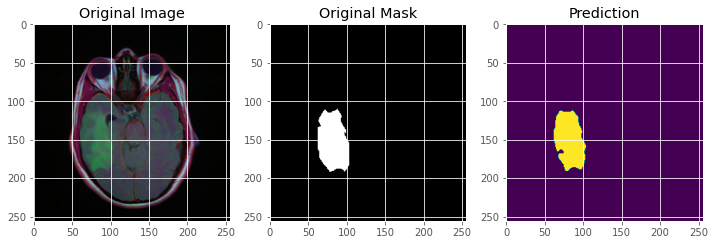

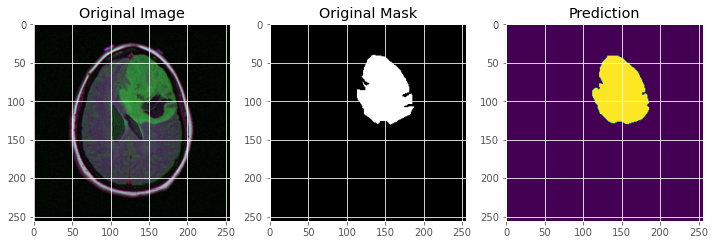

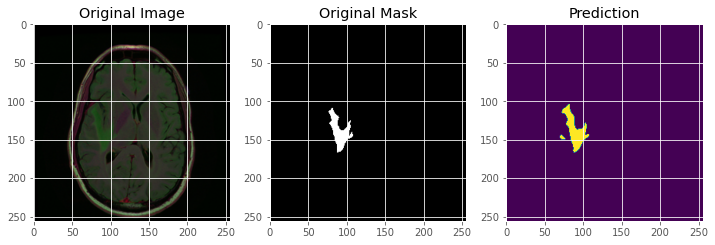

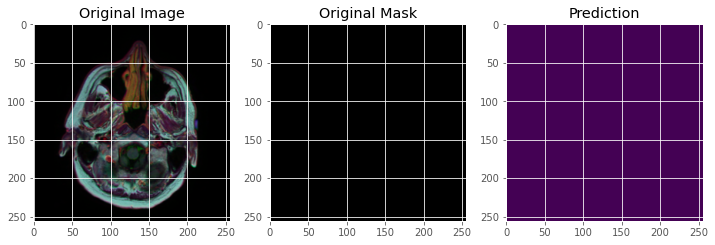

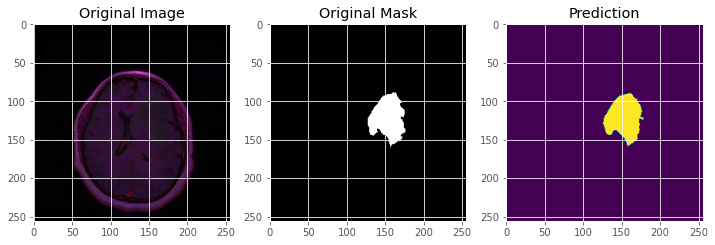

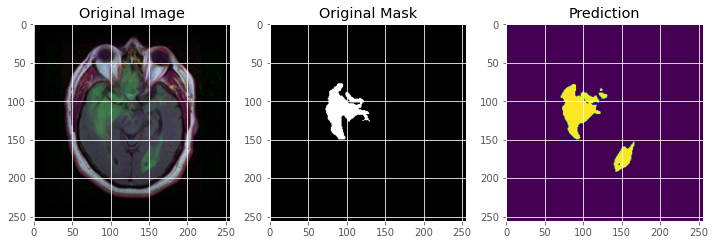

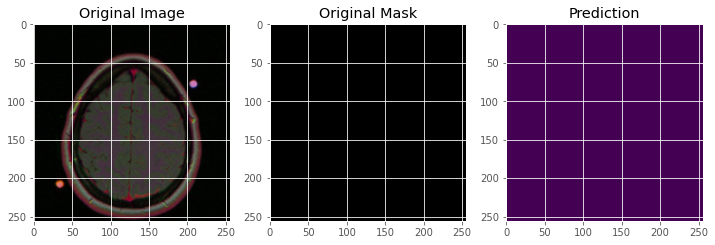

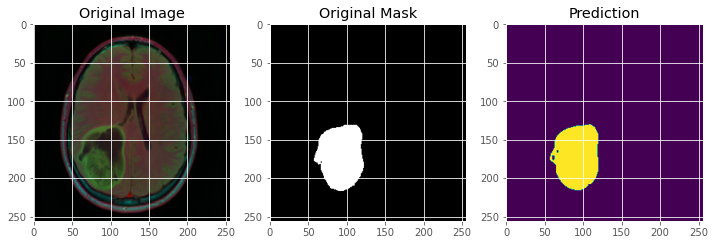

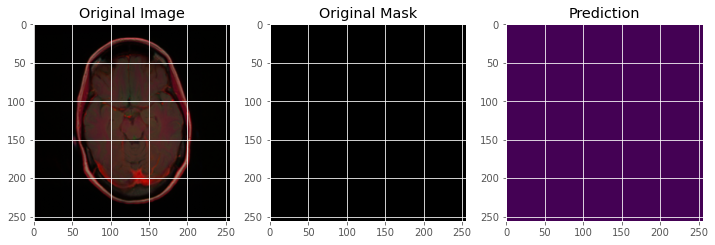

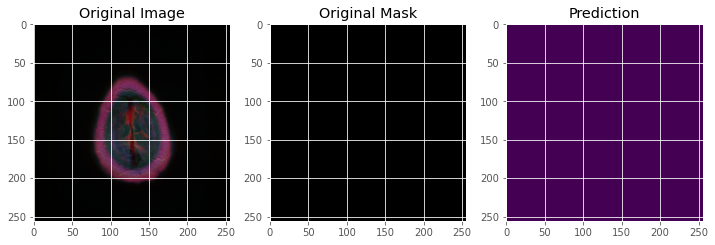

In [ ]:
for i in range(30):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['filename'].iloc[index])
    img = cv2.resize(img ,(im_height, im_width))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()

#External validation (using other brain MRI images with tumor)

In [ ]:
# Images in the list "l" were needed to be prepared by yourself
l = ["test1.jpg", "test2.jpg", "test3.jpg"]

for i in l:
  img = cv2.imread(i)
  img = cv2.resize(img ,(im_height, im_width))
  img = img / 255
  img = img[np.newaxis, :, :, :]
  pred=model.predict(img)
  plt.figure(figsize=(12,12))
  plt.subplot(1,2,1)
  plt.imshow(np.squeeze(img))
  plt.title('Original Image')
  plt.subplot(1,2,2)
  plt.imshow(np.squeeze(pred) > .5)
  plt.title('Prediction')
  plt.show()